In [ ]:
from __future__ import annotations
import numpy as np
import numpy.linalg as lin
import networkx as nx
import scipy
import scipy.sparse.linalg as slin
import matplotlib.pyplot as plt

#  Basic Functionality 

Here we supply the essential functions needed for experiments. This includes the ability to find the term relating to the spectral norm which is abstracted in a function because it may change. 

Also included a generators for ER graphs, the ability to compute the optimal price vector for a graph and the optimal profit of a graph if we were to apply this price vector. 

In [45]:
# Linear algebra
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=np.inf)
    # return np.sqrt(slin.eigs(A.T @ A, k=1, which="LM", return_eigenvectors=False, tol=1e-10)[0])


# Graph makers
def makeSimilarGraph(G: nx.DiGraph) -> np.matrix:
    """ Generates the new graph with the same in/out degree as the orginal
        -------
        Return adj. matrix of graph
    """
    sequence_in = [d for _, d in G.in_degree]
    sequence_out = [d for _, d in G.out_degree]
    return nx.to_numpy_matrix(
        nx.directed_configuration_model(sequence_in, sequence_out, create_using=nx.DiGraph),
        dtype="d"
    )


# Graph Generators
def makeERGraph(n: int, p: float) -> np.matrix:
    """ Generates Random Erdos-Renyi Graphs with n vertices and link probability p
        ------
        return Adjacency graph of matrix and the networkx DiGraph object
    """
    G = nx.generators.fast_gnp_random_graph(n, p, directed=True)
    # sortG = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
    return nx.to_numpy_matrix(G, dtype="d"), G


def centralty(A: np.matrix, rho: float, alpha,k) -> np.matrix:
    """

    Parameters
    ----------
    A : np matrix
    rho : network effect

    Returns
    -------
    Centrality vector as described in paper
    """
    n = A.shape[0]

    ident = np.eye(n, n)
    ones = np.ones((n, 1))
    ApA = A + A.T
    eig = specNorm(ApA)
    alpha = rho / eig
    central = lin.inv(ident - (alpha * ApA))
    central = central @ ones  # Checked.  this > 0
    return central


# Paper related properties
def applyPriceVector(A: np.matrix, v: np.matrix, rho: float, a: int | float, c: int | float) -> (float, bool):
    """

    Parameters
    ----------
    A : Graph
    v : price vector
    rho : network strength
    a : Stand alone strength
    c : Marginal cost. Should be less than a

    Returns
    -------
    Profit in this network if prces v were applied.
    And if result is valid or not
    """
    n = A.shape[0]
    ident = np.eye(n, n)
    ones = np.ones((n, 1))
    ApA = A + A.T
    # spN = specNorm(ApA)  # Sometimes scipy return x+0i, this is to discard warning
    alpha = (rho / specNorm(ApA))
    consumption = (2 * alpha) * A
    consumption = ident - consumption
    consumption = 0.5 * lin.inv(consumption)  # This is entirely in the range [0,1] ^ checked

    consumption = consumption @ ((a * ones) - v)
    valid = 1
    if (np.min(consumption) < 0):
        valid = 0
    return ((v - (c * ones)).T @ consumption)[0, 0], valid


def priceVector(A: np.matrix, rho: float, a: int | float, c: int | float,k = None) -> np.matrix:
    """
    Parameters
    ----------
    A : Network
    rho : network strength
    a : stand alone util
    c : marginal cost. Should be less than a

    Returns
    -------
    Vector reprsenting what price to charge individual i
    """
    n = A.shape[0]
    ones = np.ones((n, 1))
    alpha = rho / specNorm(A + A.T)
    central = centralty(A, rho, alpha,k)  # This should be A not A + A.T because of how centralty function is designed
    dif = A - A.T
    pv1 = ((a + c) / 2) * ones
    pv2 = ((a - c) * alpha * 0.5) * (dif @ central)
    return pv1 + pv2


def optimalProfit(A: np.matrix, n: int, a: int | float, c: int | float, rho: float):
    """
    Parameters
    ----------
    A : Network
    n : size of network
    rho : network strength
    a : stand alone util
    c : marginal cost. Should be less than a
    Returns
    -------
    True profit. Should be the same as applyPriceVector(A, pricevector(A,...),...)
    """
    one = np.ones((n, 1))
    alpha = rho / specNorm(A + A.T)

    t1 = lin.inv(np.eye(n, n) - (alpha * (A + A.T)))
    total = one.T @ t1 @ one
    total = ((a - c) * (a - c) / 8) * total
    return np.real(total[0, 0])



# Metrics
Here are functions used "one level up" in terms of abstraction from finding the price vectors. This includes things like computing the fractional regret of a applying a given vector v to a graph instad of its true optimal price vector. 

In [76]:

def fractionalRegret(A, v, n, rho, a, c):
    """

    Parameters
    ----------
    A : Network
    v : price vector to compare to
    rho : network strength
    n : number of nodes
    a : stand alone util
    c : marginal cost. Should be less than a

    Returns
    -------
    1 - (profit of A using v)/(profit of A using best choice)
    """
    discrim = optimalProfit(A, n, a, c, rho)  # Optimal profit
    # I have check and the formula for optimal profit does match applypricevector(A, pricevector(A,...), params)
    appliedProf,v  = applyPriceVector(A, v, rho, a, c) # Profit at v
    return 1 - (appliedProf / discrim) , v 



# Gaps applying price vector of guesses to true graph G
def getGapRev(A, test, rho, a, c):
    """ Apply optimal profit price vector guess graph to test graph test and A. Return pair of profits"""
    optimalVector = priceVector(test, rho, a, c)
    profitWithGuessV = applyPriceVector(A, optimalVector, rho, a, c)
    trueProfit = applyPriceVector(A, priceVector(A, rho, a, c), rho, a, c)
    return trueProfit, profitWithGuessV


# Applying the true optimal profit vector to guesses
# Currently not using because it seems backwards of what I want
def getGaps(n, p, rho, a, c, i, results, n_trials):
    A, G = makeERGraph(n, p)
    results[i] = np.average([getGap(A, makeSimilarGraph(G), rho, a, c) for j in range(n_trials)])
    return i


# Apply the price vector that each guess produces to the true graph and take average.
def getGapsReverse(n, p, rho, a, c, i, results, n_trials):
    A, G = makeERGraph(n, p)
    results[i] = np.average([getGapRev(A, makeSimilarGraph(G), rho, a, c) for j in range(n_trials)])
    return i


# Here we apply the average optimal price vector of the guesses to the true graph G
# I get a warning about discarding complex values, values should never complex for this problem
# and when I check they are all +0i so ?


def getAverageGap(n, p, rho, a, c, i, results, n_trials):
    A, G = makeERGraph(n, p)
    n = A.shape[0]
    trueProfit = applyPriceVector(A, priceVector(A, rho, a, c), rho, a, c)
    # the average vector initilized with sample size of 1
    averageV = priceVector(makeSimilarGraph(G), rho, a, c)
    # And another n_trials-1 trials
    for j in range(n_trials - 1):
        averageV += priceVector(makeSimilarGraph(G), rho, a, c)
    averageV /= n_trials  # Scaling
    profit, v = applyPriceVector(A, averageV, rho, a, c)
    results[i] = np.real(trueProfit - profit)


# Tests
Here are the collection of various tests we can run. 

In [77]:
def profitDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        res_par[j],b0 = applyPriceVector(A_true, v_par, rho, a, c)
        res_seq[j],b1 = applyPriceVector(A_true, v_seq, rho, a, c)
        valid_par += b0
        valid_seq += b1
        
    return [res_par, res_seq], [valid_par/n_trials, valid_seq/n_trials]


def regretDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        res_par[j],b0 = fractionalRegret(A_true, v_par, n, rho, a, c)
        res_seq[j],b1 = fractionalRegret(A_true, v_seq, n, rho, a, c)
        valid_par += b0
        valid_seq += b1
        
    return [res_par, res_seq], [valid_par/n_trials, valid_seq/n_trials]

def regretAveragedVector(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    v_aver = np.zeros((n,1))
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        v_aver += v_seq
        res_par[j],b0 = fractionalRegret(A_true, v_par, n, rho, a, c)
        res_seq[j],b1 = fractionalRegret(A_true, v_seq, n, rho, a, c)
        valid_par += b0
        valid_seq += b1
    v_aver /= n_trials
    res_avg, b0 = fractionalRegret(A_true, v_aver, n, rho, a, c)
    return [res_par, res_seq, res_avg], [valid_par/n_trials, valid_seq/n_trials]

def walkDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float,k : int):
    results = np.zeros(n_trials)
    res = np.zeros((n_trials,))
    for j in range(n_trials):
        A_true, G_true = makeERGraph(n, p)
        trueP = optimalProfit(A_true,n, a, c, rho)
        v = priceVector(A_true, rho, a, c,k)
        res[j] = fractionalRegret(A_true, v, n, rho, a, c)[0]
    return res

def rawProfitDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    res_par = []
    res_seq = []
    A_true, G_true = makeERGraph(n, p)
    for j in range(n_trials):
        A_seq = makeSimilarGraph(G_true)
        A_par, G_par = makeERGraph(n,p)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        res_par.append(applyPriceVector(A_true, v_par, rho, a, c)[0])
        res_seq.append(applyPriceVector(A_true, v_seq, rho, a, c)[0])
    return res_par, res_seq

def priceVectorDifference(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    res_par = np.zeros(n_trials)
    res_seq = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    v_tre = priceVector(A_true, rho, a, c)
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        v_par = priceVector(A_par, rho, a, c)
        res_par[j] = np.linalg.norm(v_tre - v_par)
        A_seq = makeSimilarGraph(G_true)
        v_seq = priceVector(A_seq, rho, a, c)
        res_seq[j] = np.linalg.norm(v_tre - v_seq)
    return res_par, res_seq



# Effects of different Norms
Reporting for n=1500, rho=0.9, p=sqrt(log(n))/n, a=5, c=4 the variance of profits and the fraction of valid samples. 

## Infinity Norm

In [78]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=np.inf)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("Infinity Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

Infinity Norm
Same Parameter var 5.530802791207017
Same Sequence var 0.00018164659086119313
Same Parameter mean 250.7374147202458
Same Sequence mean 266.8143721390223
Same Parameter ratio 0.98
Same Sequence ratio 1.0


(None, None)

## Frobenieus Norm
It appears this norm is 2 large so the network effect is small

In [83]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("Frob Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

Frob Norm
Same Parameter var 6.055709145972346e-05
Same Sequence var 4.395560819121605e-09
Same Parameter mean 198.09160610170974
Same Sequence mean 198.32122203829078
Same Parameter ratio 1.0
Same Sequence ratio 1.0


(None, None)

## 1 Norm

In [80]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("One Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Averager Regret", np.mean(regret_par), np.mean(regret_seq))
print("Variance Regret", np.var(regret_par), np.var(regret_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

One Norm
Same Parameter var 5.547175927535045
Same Sequence var 0.00038423646498515383
Same Parameter mean 276.90915529274736
Same Sequence mean 298.2748858239605
Averager Regret 0.0702081904719786 0.0013039440217975052
Variance Regret 9.38475326342792e-05 1.6521638790102961e-09
Same Parameter ratio 0.98
Same Sequence ratio 1.0


(None, None)

## Nuclear norm

In [20]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord="nuc")
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
#[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
#[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
#print("One Norm")
#print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
#print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
#print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

## 2 Norm
This is very confusing and worrying. The results show that under the 2 norm same parameter graphs are likely to be malformed often. Also this code takes much longer to run than the others

In [21]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=2)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
"""
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("2 Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)"""

'\n[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)\n[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)\nprint("2 Norm")\nprint("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))\nprint("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))\nprint("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)'

We conclude that seemingly any choice of norm besides 2-norm is sufficient. It is unclear to me if I need to weight these norms in someway to be bigger/smamer.

# Limited Walk Size
One question we have asked is if knowing the degrees of each matrix is sufficient perhaps knowing the reach of each node in two steps is better because it specifies the graph more. Here instead of generating new graphs specificied by this information we will look at the regret using only the true graph but with truncated centralities

In [81]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=np.inf)
def centralty(A: np.matrix, rho: float, alpha, k=None) -> np.matrix:
    """

    Parameters
    ----------
    A : np matrix
    rho : network effect
    k : size of walk to take in network

    Returns
    -------
    Centrality vector as described in paper
    """
    n = A.shape[0]

    if k is None:

        ident = np.eye(n, n)
        ones = np.ones((n, 1))
        ApA = A + A.T
        eig = specNorm(ApA)
        alpha = rho / eig
        central = lin.inv(ident - (alpha * ApA))
        central = central @ ones  # Checked.  this > 0
        return central
    else:
        one = np.ones((n,1))
        ApA = A + A.T
        alpha = rho / specNorm(ApA)
        total = alpha * ApA
        base = alpha * np.eye(n, n)
        for i in range(1,k+1):
            total = total + np.linalg.matrix_power(base, i)
        return total @ one   

In [82]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
k = 1
v = walkDistribution(n, p, n_trials, rho, a, c,k)
print("k is ", k)
print("Mean Loss", np.mean(v))
print("Variance", np.var(v))
k = 2 
v = walkDistribution(n, p, n_trials, rho, a, c,k)
print("k is ", k)
print("Mean Loss", np.mean(v))
print("Variance", np.var(v))
k = 10
v = walkDistribution(n, p, n_trials, rho, a, c,k)
print("k is ", k)
print("Mean Loss", np.mean(v))
print("Variance", np.var(v))
k = None
v = walkDistribution(n, p, n_trials, rho, a, c,k)
print("k is ", k)
print("Mean Loss", np.mean(v))  
print("Variance", np.var(v))

k is  1
Mean Loss 0.018024916034904314
Variance 9.969979182075297e-06
k is  2
Mean Loss 0.017781921112992136
Variance 1.108238153925224e-05
k is  10
Mean Loss 0.017098205913536443
Variance 9.909528952127189e-06
k is  None
Mean Loss -3.9968028886505634e-17
Variance 1.2018295891042114e-31


As we see there is very little advanage in increasing the step size and as a ratio a sizable tighening of variance. Also notice when k = None the result is essentially 0(it should be exactly 0 with perfect arithemtic)

## Regret as a function of N


In [106]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)

vars_par = []
vars_seq = []
regrets_par = []
regrets_seq = []
ns = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
for n in ns:
    print("n is ", n)
    p = np.sqrt(np.log(n))/n
    n_trials = 15
    rho = 0.9
    a = 5
    c = 4
    [res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
    [regret_par, regret_seq], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
    vars_par.append(np.var(res_par))
    vars_seq.append(np.var(res_seq))
    regrets_par.append(np.mean(regret_par))
    regrets_seq.append(np.mean(regret_seq))



n is  100
n is  500
n is  1000
n is  1500
n is  2000
n is  2500
n is  3000
n is  3500
n is  4000


In [107]:
regret_par


array([0.06131082, 0.05538287, 0.06151693, 0.05218268, 0.04735509,
       0.05396547, 0.05530286, 0.06804657, 0.05982917, 0.06332429,
       0.05556536, 0.0520121 , 0.0607981 , 0.05918105, 0.06844871])

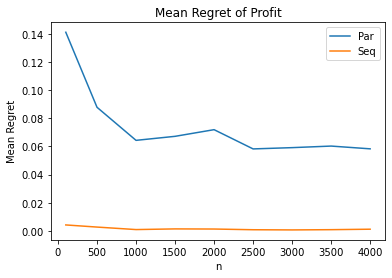

In [108]:
#plt.plot(ns, vars_par, label="Par")
#plt.plot(ns, vars_seq, label="Seq")
#plt.legend()
#plt.xlabel("n")
#plt.ylabel("Variance")
#plt.title("Variance of Profit")
#plt.show()
plt.plot(ns, regrets_par, label="Par")
plt.plot(ns, regrets_seq, label="Seq")
plt.xlabel("n")
plt.ylabel("Mean Regret")
plt.title("Mean Regret of Profit")
plt.legend()
plt.show()
#plt.savefig("RegretVN.png")

In [86]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)

vars_par = []
vars_seq = []
regrets_par = []
regrets_seq = []
n = 2000
p0 = 1.1/n
p1 = np.log(n)/n
steps = 20
ps = np.linspace(p0, p1, steps)
for p in ps:
    n_trials = 15
    rho = 0.9
    a = 5
    c = 4
    [res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
    [regret_par, regret_seq], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
    vars_par.append(np.var(res_par))
    vars_seq.append(np.var(res_seq))
    regrets_par.append(np.mean(regret_par))
    regrets_seq.append(np.mean(regret_seq))



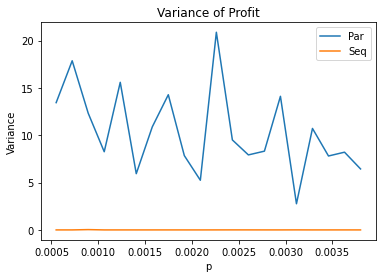

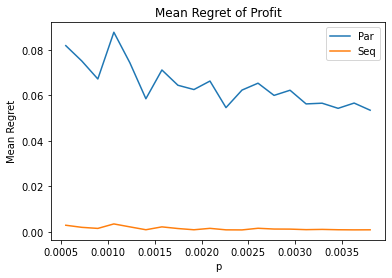

In [87]:
plt.plot(ps, vars_par, label="Par")
plt.plot(ps, vars_seq, label="Seq")
plt.legend()
plt.xlabel("p")
plt.ylabel("Variance")
plt.title("Variance of Profit")
plt.show()
plt.plot(ps, regrets_par, label="Par")
plt.plot(ps, regrets_seq, label="Seq")
plt.xlabel("p")
plt.ylabel("Mean Regret")
plt.title("Mean Regret of Profit")
plt.legend()
plt.show()

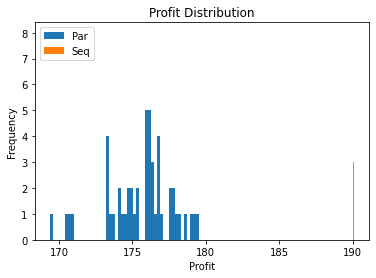

In [88]:
n = 1000
p = np.sqrt(np.log(n))/n
n_trials = 50
[results_par, results_seq] = rawProfitDistribution(n,p, n_trials, rho, a, c);
plt.hist(results_par, bins=50, label="Par")
plt.hist(results_seq, bins=50, label="Seq")
plt.legend()
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution")
plt.show()

In [89]:
print("Mean Profit", np.mean(results_par))
print("Mean Profit", np.mean(results_seq))
print("Variance", np.var(results_par))
print("Variance", np.var(results_seq))


Mean Profit 175.5580840526465
Mean Profit 190.0763440534941
Variance 4.822701579863599
Variance 0.0022592546116030074


In [90]:
n = 1000
p = np.sqrt(np.log(n))/n
n_trials = 50
[results_par, results_seq] = priceVectorDifference(n,p, n_trials, rho, a, c);


In [91]:
print("Mean Price Vector Difference", np.mean(results_par))
print("Mean Price Vector Difference", np.mean(results_seq))
print("Variance", np.var(results_par))
print("Variance", np.var(results_seq))

Mean Price Vector Difference 5.328598162192485
Mean Price Vector Difference 0.6955554596487673
Variance 0.1531004113135609
Variance 0.0008769255243096399


In [92]:
n = 2000
p = np.sqrt(np.log(n))/n
n_trials = 50
[par,seq, avg], [ratio_par, ratio_seq] = regretAveragedVector(n,p, n_trials, rho, a, c);

In [93]:
print("Regret Par", np.mean(par))
print("Regret Seq", np.mean(seq))
print("Regret Avg", np.mean(avg))
print("Variance", np.var(par))
print("Variance", np.var(seq))

Regret Par 0.07078296603746796
Regret Seq 0.0016318700282464094
Regret Avg 0.0007801610171417339
Variance 7.487281909193192e-05
Variance 2.501893911125911e-08
